In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", 100)


# Create Dataframe
df = pd.read_csv('marketing_campaign.csv', sep='\t')

# Print shape of dataset
print(df.shape)

(2240, 29)


In [22]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

Income 1.07143 % missing values


In [23]:
# statistics on numerical columns (Null cols)
df[features_with_na].select_dtypes(exclude='object').describe()

Income
count    2216.000000
mean    52247.251354
std     25173.076661
min      1730.000000
25%     35303.000000
50%     51381.500000
75%     68522.000000
max    666666.000000

In [24]:
#Age
df.Income.fillna(df.Income.median(), inplace=True)

In [25]:
df.duplicated().sum()

np.int64(0)

**Remove ```Z_CostContact``` and ```Z_Revenue``` columns from the dataset as contains only constant value, therefore doesn't create any variance in the dataset.**


In [26]:
columns_to_drop = ['ID', 'Z_CostContact','Z_Revenue']
for column in columns_to_drop:
    df.drop(column, inplace=True, axis=1)
    print(f"Column {column} is dropped.")

Column ID is dropped.
Column Z_CostContact is dropped.
Column Z_Revenue is dropped.


# Feature Engineering

Feature engineering refers to manipulation — addition, deletion, combination, mutation — of your data set to improve machine learning model training, leading to better performance and greater accuracy. Effective feature engineering is based on sound knowledge of the business problem and the available data sources.

## Feature Extraction
- We will extract and create some of the meaningfull features.

### Repeating some steps from EDA
### The following code creates features that would be helpful to describe the profile of the customer 


In [27]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format = '%d-%m-%Y')

In [28]:
from datetime import datetime

raw_df = df.copy() 

df['Age'] = 2025 - df['Year_Birth']

df['Education'].replace({'Basic':0, '2n Cycle':1, 'Graduation':2, 'Master':3, 'PhD':4}, inplace =True)

df['Marital_Status'].replace({'Married':1, 'Together':1, 'Single':0, 'Divorced':0, 'Widow':0, 'Alone':0 ,'Absurd':0, 'YOLO':0 }, inplace =True)

df['Children'] = df['Teenhome'] + df['Kidhome']

df['Family_Size'] = df['Marital_Status'] + df['Children'] + 1

df['Total_Spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'] 
df['Total Promo'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']


df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
today = datetime.today()
df['Days_as_Customer'] = (today -df['Dt_Customer']).dt.days
df['Offer_responded_to'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']
df['Parental Status']= np.where(df['Children']>0, 1,0)




#columns_to_drop = ['Kidhome', 'Teenhome']
#df.drop(columns=columns_to_drop, axis = 1 , inplace =True)

df.rename(columns={"Marital_Status": "Marital Status","MntWines": "Wines","MntFruits":"Fruits",
                   "MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets",
                   "MntGoldProds":"Gold","NumWebPurchases": "Web","NumCatalogPurchases":"Catalog",
                   "NumStorePurchases":"Store","NumDealsPurchases":"Discount Purchases"},
          inplace = True)

df = df[["Age","Education","Marital Status","Parental Status","Children","Income","Total_Spending","Days_as_Customer","Recency","Wines","Fruits","Meat","Fish","Sweets","Gold","Web","Catalog","Store","Discount Purchases","Total Promo","NumWebVisitsMonth"]]


### Types of Features

#### Numeric Features

In [29]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'object'] 
print('Num of numerical features : ', len(num_features))

Num of numerical features :  21


#### Categorical Features

In [30]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'object'] 
print('Num of categorical features : ', len(cat_features))

Num of categorical features :  0


#### Discrete Features

In [31]:
discrete_features = [feature for feature in num_features if len(df[feature].unique()) <= 25] 
print('Num of discrete features : ', len(discrete_features))

Num of discrete features :  10


#### Continuous Features

In [32]:
continuous_features = [feature for feature in num_features if feature not in discrete_features]
print('Num of continuous feartures :', len(continuous_features))

Num of continuous feartures : 11


 ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable “ 
 
**- We can see there are some Multicollinearity in this dataset**



In [33]:
continuous_features

['Age',
 'Income',
 'Total_Spending',
 'Days_as_Customer',
 'Recency',
 'Wines',
 'Fruits',
 'Meat',
 'Fish',
 'Sweets',
 'Gold']

## Outliers Detection

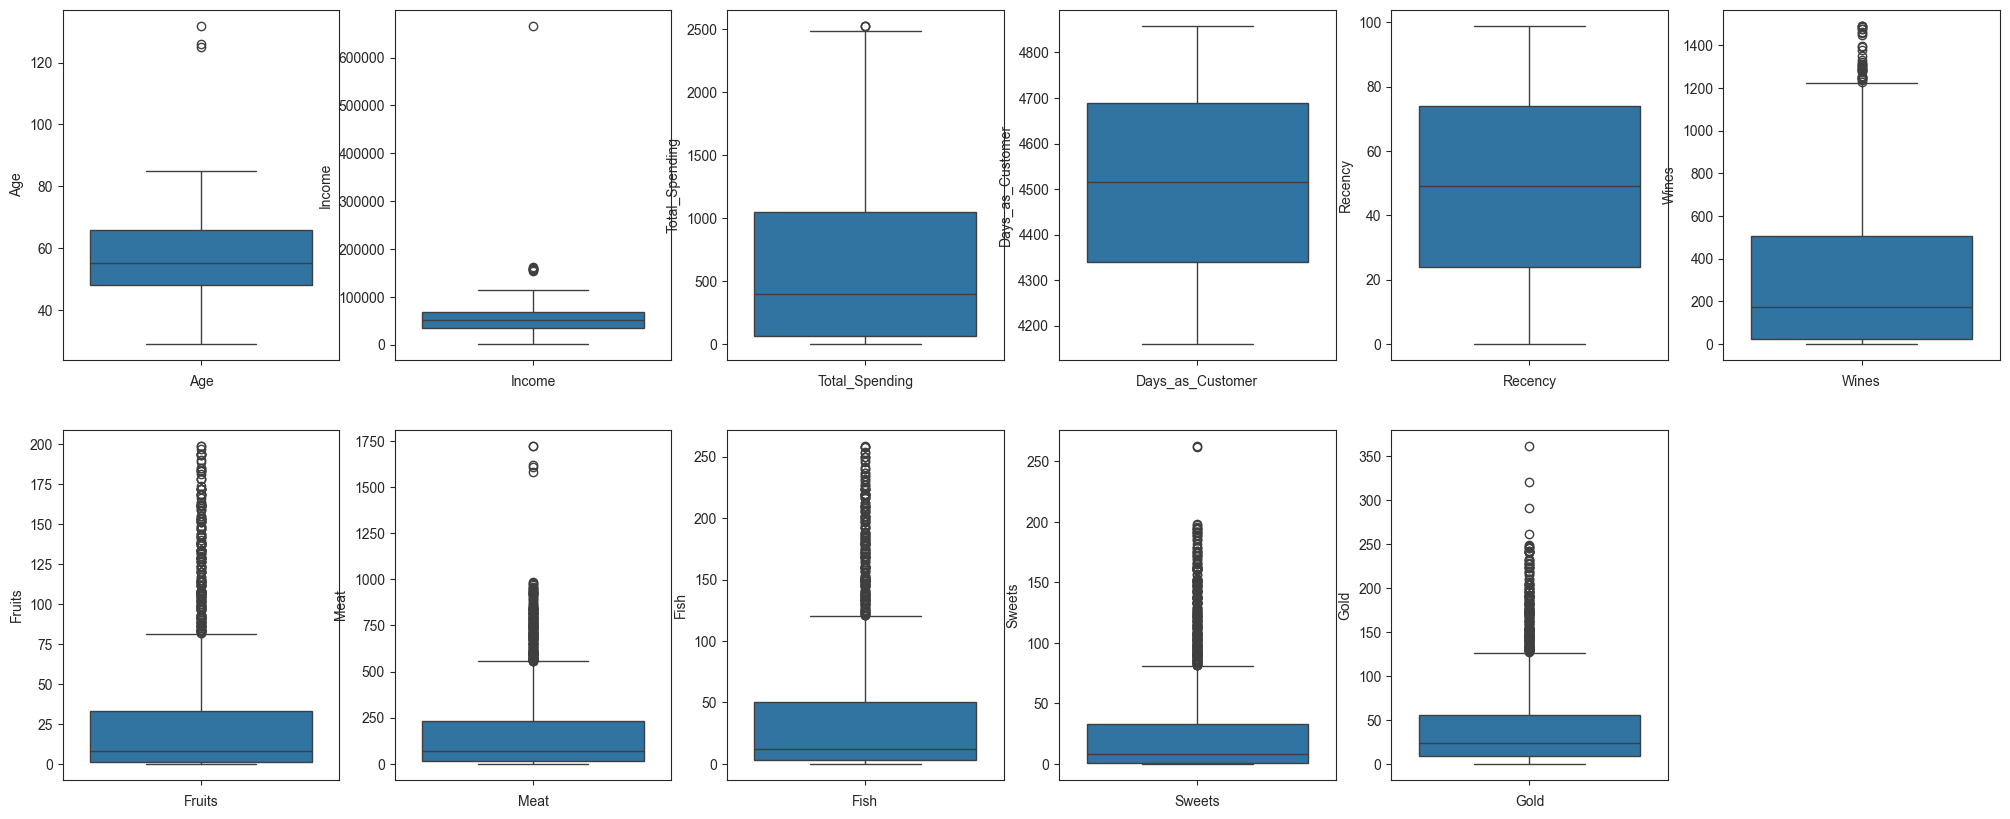

In [34]:
cont_features = continuous_features.copy()
plt.figure(figsize=(25,10))

for i in range (len(cont_features)):
    plt.subplot(2,6,i+1)
    sns.set_style('ticks')
    plt.xlabel(cont_features[i])
    ax = sns.boxplot(df[cont_features[i]])

**Report**
- We can see, there are no such outliers in ```Recency``` and ```Days_as_Customer``` Column
- But there are outliers in following columns - 
    - Income
    - Wines
    - Fruits
    - Meat
    - Fish
    - Sweets
    - Gold
    - Age
    - Total Spending

#### Detecting Outlier and Capping it

In [35]:
def detect_outliers(col):
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n####', col, '####')
    print('percentile25',percentile25)
    print('percentile75', percentile75)

    iqr = percentile75 - percentile25

    upper_limit = percentile75 + 1.5*iqr
    lower_limit = percentile25 - 1.5*iqr

    print('upper_limit', upper_limit)
    print('lower_limit', lower_limit)

    df.loc[(df[col]>upper_limit), col] = upper_limit
    df.loc[(df[col]<lower_limit), col] = lower_limit
    return df


In [36]:
for col in continuous_features:
    detect_outliers(col)


#### Age ####
percentile25 48.0
percentile75 66.0
upper_limit 93.0
lower_limit 21.0

#### Income ####
percentile25 35538.75
percentile75 68289.75
upper_limit 117416.25
lower_limit -13587.75

#### Total_Spending ####
percentile25 68.75
percentile75 1045.5
upper_limit 2510.625
lower_limit -1396.375

#### Days_as_Customer ####
percentile25 4340.75
percentile75 4689.0
upper_limit 5211.375
lower_limit 3818.375

#### Recency ####
percentile25 24.0
percentile75 74.0
upper_limit 149.0
lower_limit -51.0

#### Wines ####
percentile25 23.75
percentile75 504.25
upper_limit 1225.0
lower_limit -697.0

#### Fruits ####
percentile25 1.0
percentile75 33.0
upper_limit 81.0
lower_limit -47.0

#### Meat ####
percentile25 16.0
percentile75 232.0
upper_limit 556.0
lower_limit -308.0

#### Fish ####
percentile25 3.0
percentile75 50.0
upper_limit 120.5
lower_limit -67.5

#### Sweets ####
percentile25 1.0
percentile75 33.0
upper_limit 81.0
lower_limit -47.0

#### Gold ####
percentile25 9.0
percentile75 56.0
u

#### Checking skewness after capping

In [37]:
skew_df = df[continuous_features].skew(axis= 0, skipna= True)

In [38]:
skew_df

Age                 0.120199
Income              0.090027
Total_Spending      0.860245
Days_as_Customer   -0.015216
Recency            -0.001987
Wines               1.096611
Fruits              1.233953
Meat                1.213585
Fish                1.230822
Sweets              1.213346
Gold                1.111307
dtype: float64

## Feature Transformation

### Scaling 
- **What is Feature Scaling**
    - Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step.
- **Why we use feature scaling?**
    - the feature scaling was implemented to prevent any skewness in the contour plot of the cost function which affects the gradient descent but the analytical solution using normal equation does not suffer from the same drawback.

- StandardScaler
StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.

- PowerTransformer
Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

- ColumnTransformer
Applies transformers to columns of an array or pandas DataFrame. This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space.

- SimpleImputer
SimpleImputer is a scikit-learn class which is helpful in handling the missing data in the predictive model dataset. It replaces the NaN values with a specified placeholder.

- Pipeline
The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__' .

In [39]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
outlier_features = ["Wines","Fruits","Meat","Fish","Sweets","Gold","Age","Total_Spending"] #we can find the columns which has oitliers in the EDA
numeric_features = [x for x in numeric_features if x not in outlier_features]

In [40]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [41]:
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline




dataC = df.copy()

numeric_pipeline = Pipeline(steps=
                            [("Imputer", SimpleImputer(strategy='constant', fill_value=0)), 
                             ("StandardScaler", StandardScaler())]
                           )

outlier_features_pipeline = Pipeline(steps=
                                     [("Imputer", SimpleImputer(strategy='constant', fill_value=0)),
                                      ("transformer", PowerTransformer(standardize=True))]
                                    )

preprocessor = ColumnTransformer(
    [
        ("numeric pipeline",numeric_pipeline, numeric_features),
        ("Outliers Features Pipeline", outlier_features_pipeline, outlier_features)
    ]
)

columns = dataC.columns
dataC = preprocessor.fit_transform(dataC)
scaled_data = pd.DataFrame(dataC, columns= columns )
print("After scaling, let's have a glimpse of the scaled dataset :")
scaled_data.head()

After scaling, let's have a glimpse of the scaled dataset :


Age  Education  Marital Status  Parental Status  Children    Income  \
0 -0.458383  -1.346874       -1.584605        -1.264505  0.299651  1.531185   
1 -0.458383  -1.346874        0.631072         1.396361 -0.263808 -1.190545   
2 -0.458383   0.742460       -1.584605        -1.264505  0.943420 -0.205773   
3 -0.458383   0.742460        0.631072         0.065928 -1.204881 -1.061881   
4  1.533425   0.742460        0.631072         0.065928  0.307056 -0.953012   

   Total_Spending  Days_as_Customer   Recency     Wines    Fruits      Meat  \
0        0.307039          1.409304  2.510890 -0.550785  0.349414 -0.439037   
1       -0.383664         -1.110409 -0.568720 -1.166125 -0.168236 -0.439037   
2       -0.798086          1.409304 -0.226541  1.295237 -0.685887 -0.439037   
3       -0.798086         -0.750450 -0.910898 -0.550785 -0.168236 -0.439037   
4        1.550305          0.329427  0.115638  0.064556  1.384715 -0.439037   

       Fish    Sweets      Gold       Web   Catalog     Store  \
0  0.693904  1.062784  1.487681  1.504406  1.493989  1.474200   
1 -0.130463 -1.211545 -1.001121 -1.376502 -0.889143 -0.987648   
2 -0.542647  0.748918  1.145877  0.456428  1.435812  0.579704   
3  0.281720 -1.211545 -0.403311 -0.722233 -0.110828 -0.542753   
4 -0.130463  0.123712  1.058075  0.406278  0.832291  0.741799   

   Discount Purchases  Total Promo  NumWebVisitsMonth  
0            1.196801     1.005580           1.315365  
1           -0.967034     1.240015          -1.441417  
2            0.473642     0.360856           0.661170  
3           -1.069040    -1.314808          -1.117211  
4           -0.368949    -1.033704           0.179322

### Model Building ( Clustering )

We know that our dataset it unsupervised, that means we don't have such target column. So we will be using clustering algorithms first to cluster the dataset and create target levels out of it. 

- What is Clustering?
> Using a clustering algorithm means you're going to give the algorithm a lot of input data with no labels and let it find any groupings in the data it can. Those groupings are called clusters. A cluster is a group of data points that are similar to each other based on their relation to surrounding data points.

Here for Clustering Problem statement, 4 Algorithms are used.

- K-Means Clustering
- Agglomerative Clustering
- Gaussian Mixture
- DBSCAN

### Create a function for Silhouette score plot

- **What is silhouette score**

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [42]:
# this function we take it from sklearn page for ploting silhouette with little Modification 
#ploting silhouette_plot aside with clustring results in PCA
from sklearn.metrics import silhouette_score,silhouette_samples
from matplotlib import cm

def silhouette_plot(model,range_n_clusters,X_clustering,pca,**kwargs):
    
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X_clustering) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = model(n_clusters,**kwargs)
        cluster_labels = clusterer.fit_predict(X_clustering)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_clustering, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_clustering, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
    #     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        sns.scatterplot(
            x = pca[:, 0],
            y = pca[:, 1],
            hue=cluster_labels,
            palette=sns.color_palette("colorblind", len(set(cluster_labels))),
            alpha=0.7,
            legend="full",
            ax = ax2
        )
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            f"Silhouette analysis for {model.__name__} clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )

    plt.show()

## PCA (Principal Component Analysis)
There is many high correlation feature so we will use some dimentinality reduction. 
We can use PCA

* Principal Component Analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

* Reducing the number of variables of a data set naturally comes at the expense of accuracy, but the trick in dimensionality reduction is to trade a little accuracy for simplicity. Because smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.

In [43]:
# Applying PCA
from sklearn.decomposition import PCA
df_scaled = scaled_data.copy()
var_ratio = {}
for i in range(2,18):
    pc = PCA(n_components= i)
    df_pca = pc.fit(df_scaled)
    var_ratio[i] = sum(df_pca.explained_variance_ratio_)

### Choosing PCA` n_components` and Kmeans `n_clusters` based on Clustering metrics

In [50]:
# applying PCA and displaying cluster metrices
from sklearn.cluster import KMeans
for y in range(2,8):
    print('PCA with # f components: ', y)
    pca = PCA(n_components=y)
    data_p = pca.fit_transform(df_scaled)

    for x in range(2,7):
        kmeans = KMeans(n_clusters= x)
        label = kmeans.fit_predict(data_p)
        print('Silhouette score for', x, 'Clusters: ',silhouette_score(data_p, label), '-Inertia', kmeans.inertia_)
    print()

PCA with # f components:  2
Silhouette score for 2 Clusters:  0.5284525823080037 -Inertia 9059.516817649303
Silhouette score for 3 Clusters:  0.5104310386613046 -Inertia 5130.230199139144
Silhouette score for 4 Clusters:  0.45359514224513 -Inertia 3977.98174782013
Silhouette score for 5 Clusters:  0.44892020058816284 -Inertia 3304.1622412673437
Silhouette score for 6 Clusters:  0.39478730617482966 -Inertia 2835.840323229917

PCA with # f components:  3
Silhouette score for 2 Clusters:  0.4545341667820803 -Inertia 12743.166215517904
Silhouette score for 3 Clusters:  0.4064924294196139 -Inertia 8794.759576050208
Silhouette score for 4 Clusters:  0.3325123520671443 -Inertia 7457.9520433824955
Silhouette score for 5 Clusters:  0.31770495051004977 -Inertia 6957.640841916216
Silhouette score for 6 Clusters:  0.28326233462299444 -Inertia 5855.377167613835

PCA with # f components:  4
Silhouette score for 2 Clusters:  0.4178135516036726 -Inertia 15191.290931841299
Silhouette score for 3 Cluste

**Report**
* **We can go with PCA with 2 components.**
* **We can go with Kmeans Clusters in the range of 4-6 as it has Good score with lesser Inertia compared to others**

In [52]:
# Reducing the dimensions of data
pca_final = PCA(n_components= 2, random_state= 42).fit(df_scaled)

reduced = pca_final.fit_transform(df_scaled)
pcadf = pd.DataFrame(reduced)
pcadf.columns= ['PC1', 'PC2']

pcadf.head(10)

PC1       PC2
0  4.130796  0.501128
1 -3.495762 -0.524564
2  3.032344 -0.850914
3 -2.794895 -1.108150
4  0.786623  0.794276
5  1.105595  0.967902
6  1.539461  1.352346
7 -1.842665  0.488941
8 -3.457070 -0.155104
9 -5.229841  1.478634

In [53]:
pca_final.explained_variance_ratio_

array([0.39488321, 0.10833103])

#### Elbow Method to find best Clusters for K-Means
- In the Elbow method, we are actually varying the number of clusters ( K ) from 1 – 10. For each value of K, we are calculating WCSS ( Within-Cluster Sum of Square ). WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1. When we analyze the graph we can see that the graph will rapidly change at a point and thus creating an elbow shape.

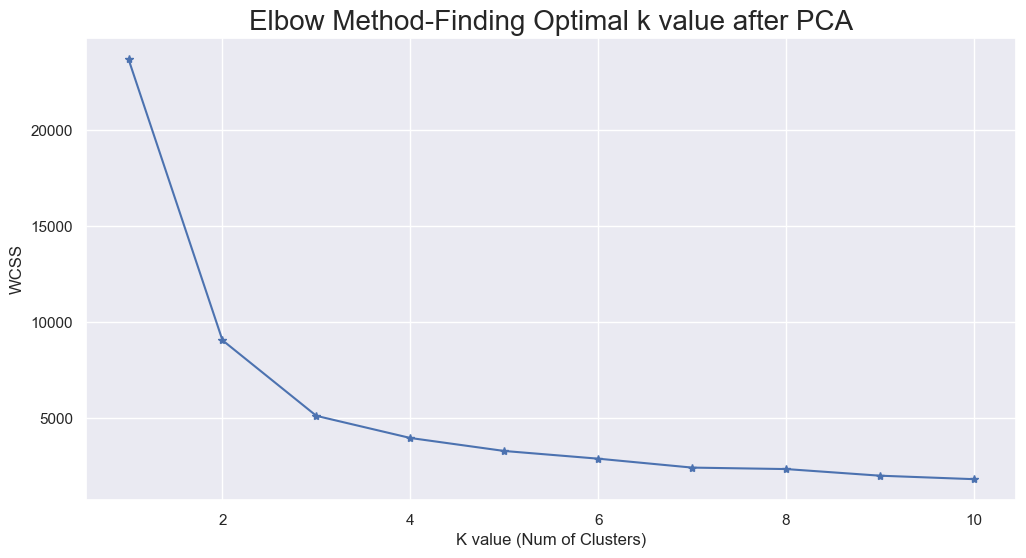

In [56]:
wcss= {}
sns.set()
plt.figure(figsize=(12,6))
for i in range(1,11): 
    km = KMeans(n_clusters=i)
    km.fit(pcadf)
    wcss[i]=km.inertia_

plt.plot(range(1,11),wcss.values(), marker='*')
plt.title('Elbow Method-Finding Optimal k value after PCA', fontsize =20)
plt.xlabel('K value (Num of Clusters)')
plt.ylabel('WCSS')
plt.show()

- Here the optimum number of cluster is 3 cluster since it is the place where the graph start to flatten out meaning that having higher number of cluster will not yield a much more fitting machine.

**Reports:**

* We will use **k = 3**, thus there will be **three clusters** in our dataset.
* We will use **KMeans Algorithm** for clustering.

#### Silhoutte Score Plot for K-Means to choose best number of clusters

For n_clusters = 3 The average silhouette_score is : 0.5104310386613046
For n_clusters = 4 The average silhouette_score is : 0.4530602335093897
For n_clusters = 5 The average silhouette_score is : 0.43089495880175194
For n_clusters = 6 The average silhouette_score is : 0.39773667197704016


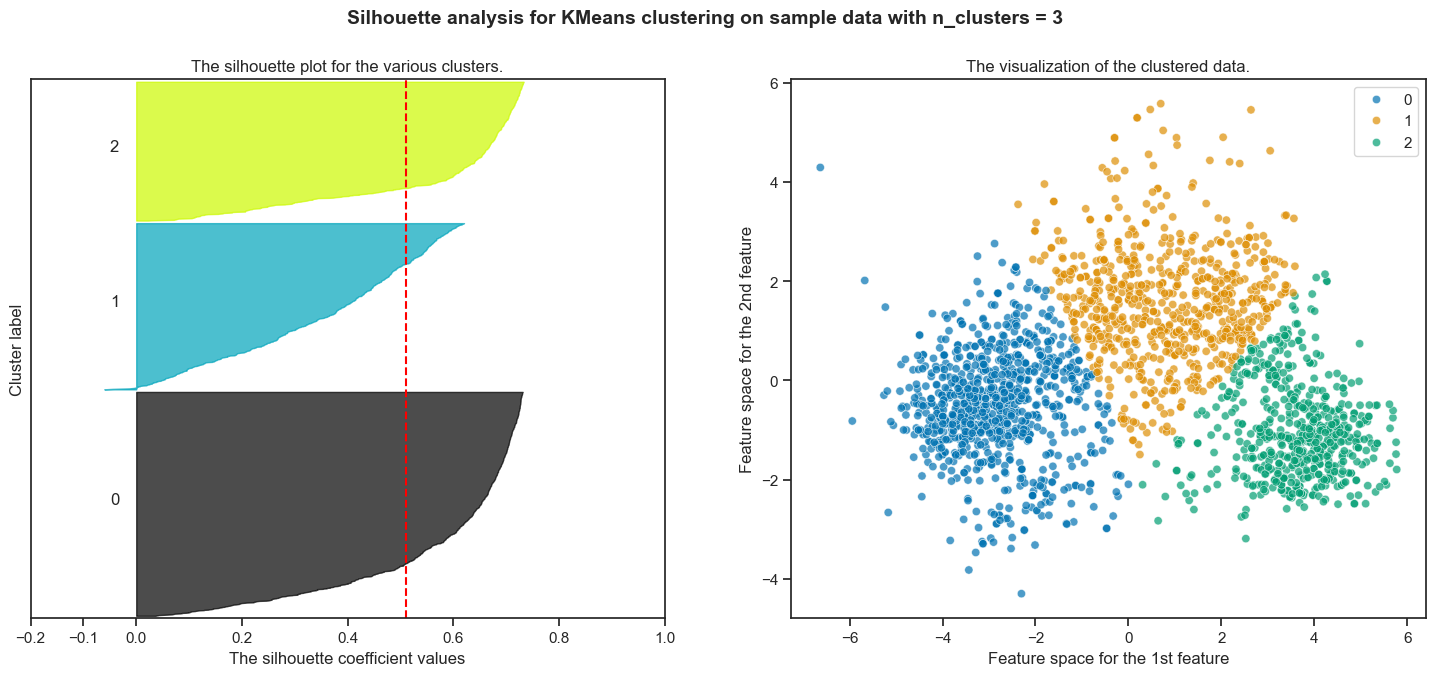

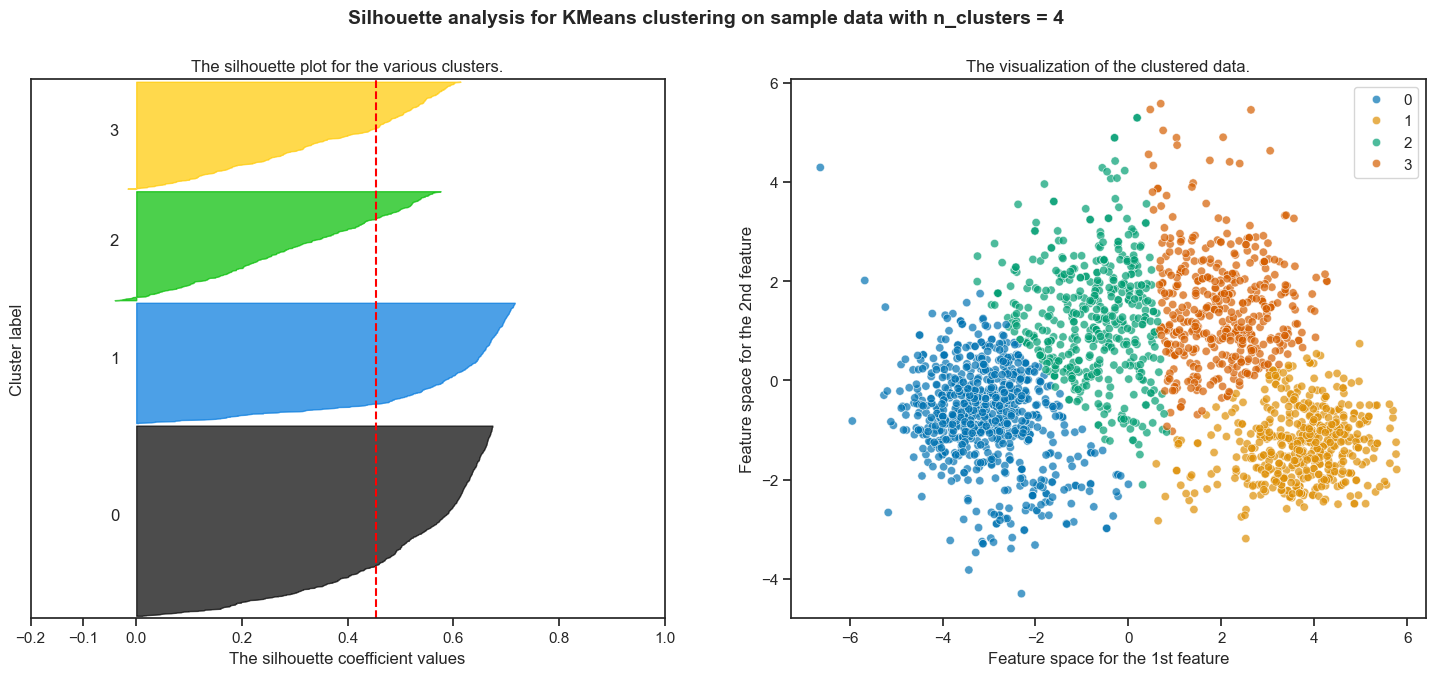

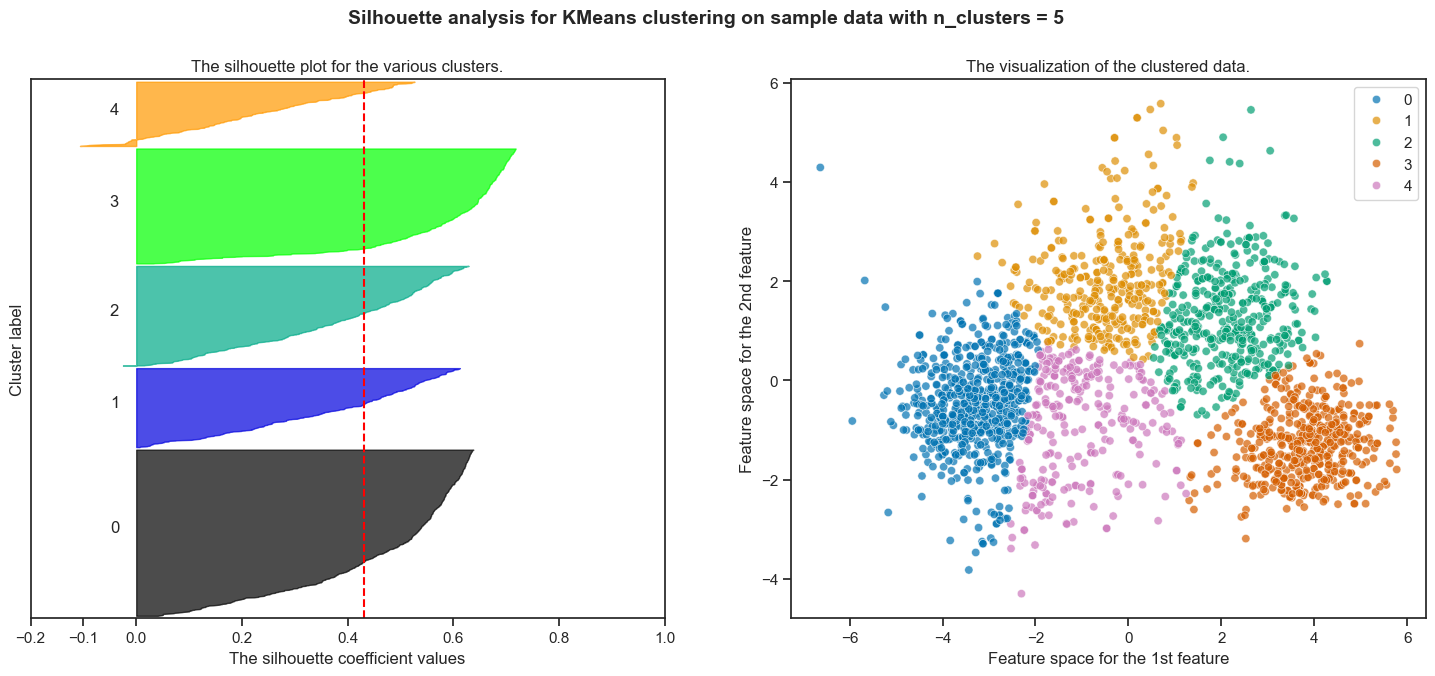

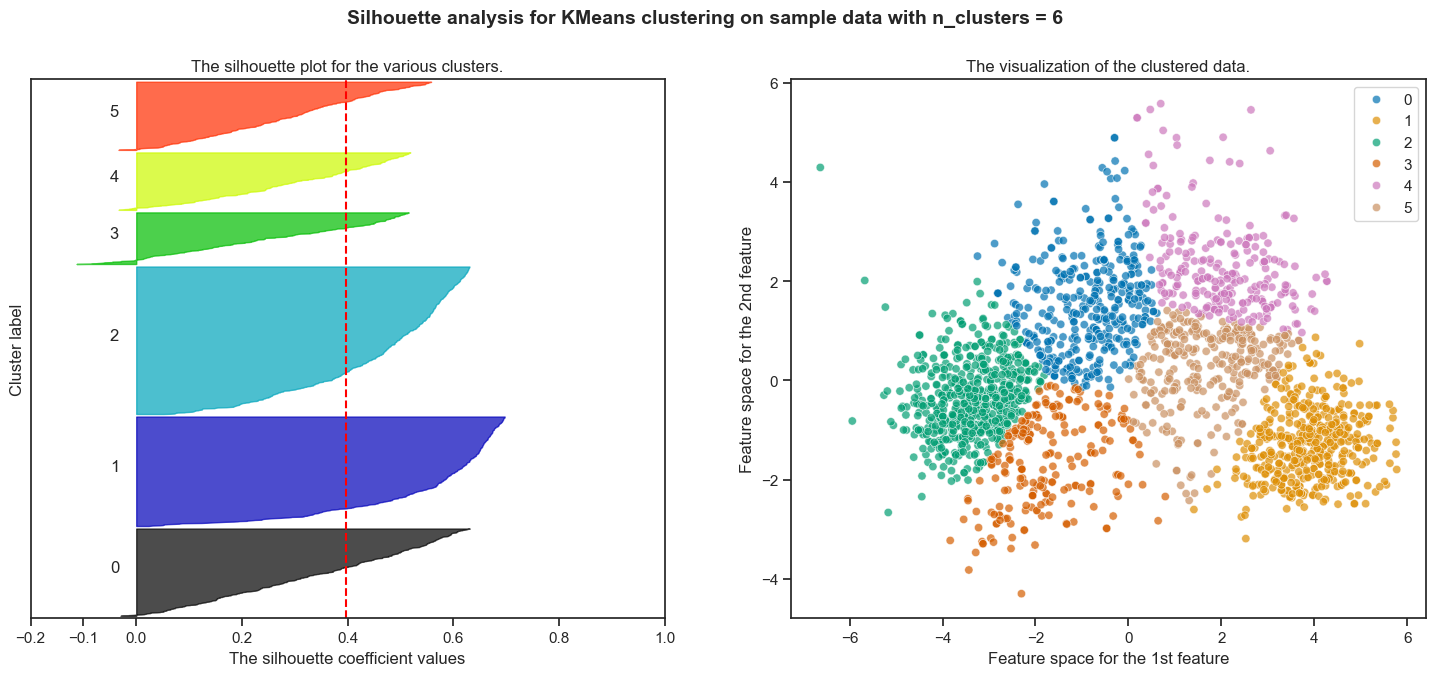

In [57]:
# We plot silhoutte score for Kmeans
# Here pcadf is pca dataframe, and Reduced is array of data after PCA.
sns.set_style('ticks')
silhouette_plot(KMeans,range(3,7), pcadf, reduced)

#### For n_clusters = 3 The average silhouette_score is : 0.5104
#### For n_clusters = 4 The average silhouette_score is : 0.4565
#### For n_clusters = 5 The average silhouette_score is : 0.42996
#### For n_clusters = 6 The average silhouette_score is : 0.390


**Conclusions**
* Clusters of 3 has good balance of Inertia and Shilloute score, we can go with with 3 clusters.


### Apply Kmeans Clustering with 3 clusters

In [58]:
# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

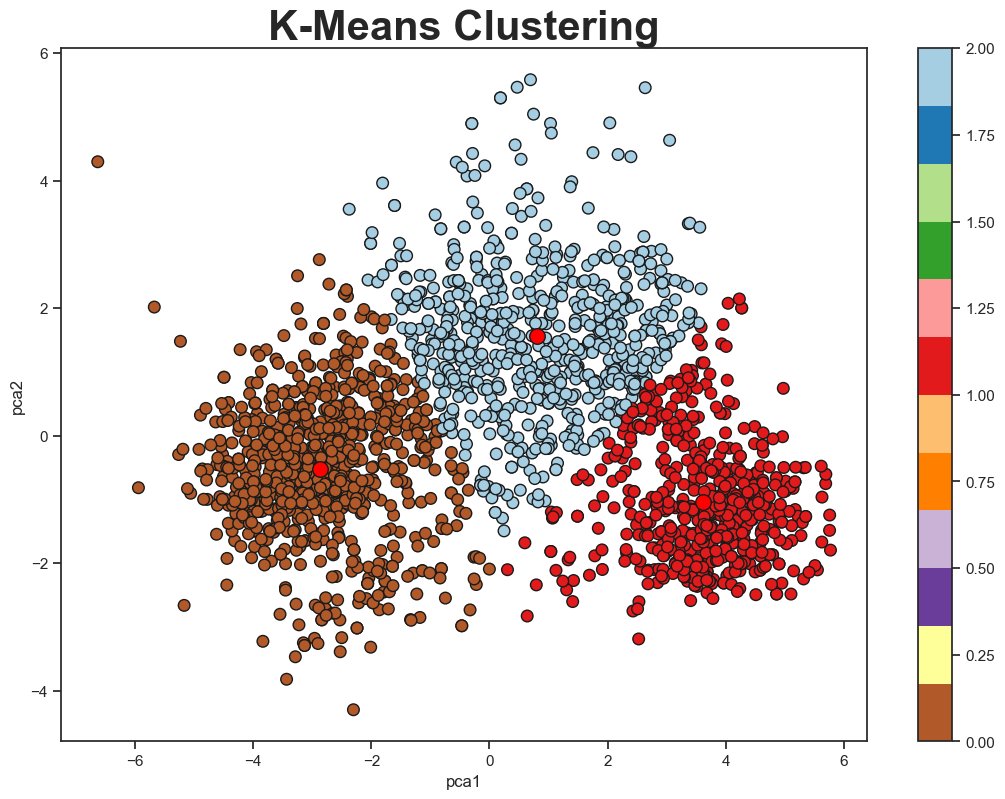

In [59]:
#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k')

### Hierarchical clustering (Agglomerative)
* Agglomerative Clustering: Also known as bottom-up approach or hierarchical agglomerative clustering (HAC). 
* A structure that is more informative than the unstructured set of clusters returned by flat clustering. This clustering algorithm does not require us to prespecify the number of clusters. 
* Bottom-up algorithms treat each data as a singleton cluster at the outset and then successively agglomerates pairs of clusters until all clusters have been merged into a single cluster that contains all data.

For n_clusters = 3 The average silhouette_score is : 0.47317685740798093
For n_clusters = 4 The average silhouette_score is : 0.4390931411550711
For n_clusters = 5 The average silhouette_score is : 0.41653809635089545
For n_clusters = 6 The average silhouette_score is : 0.3936333825910691
For n_clusters = 7 The average silhouette_score is : 0.38969769329898785


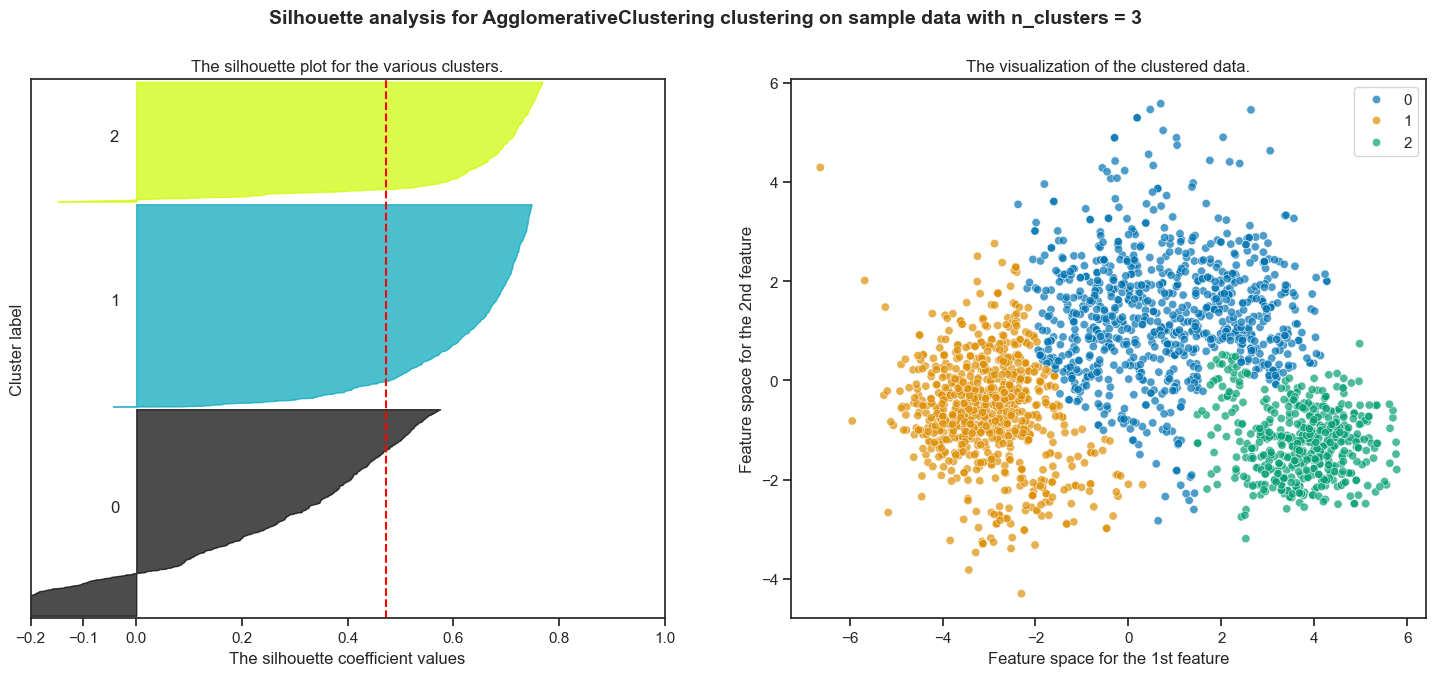

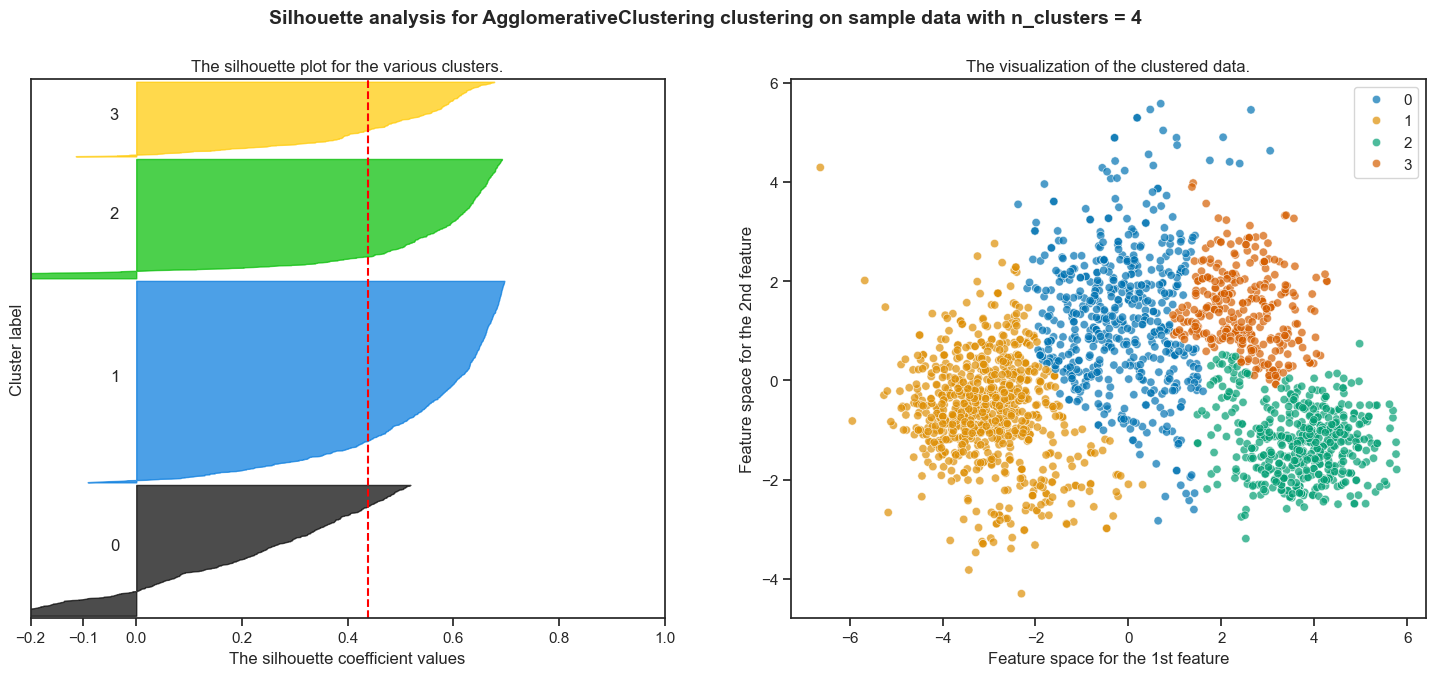

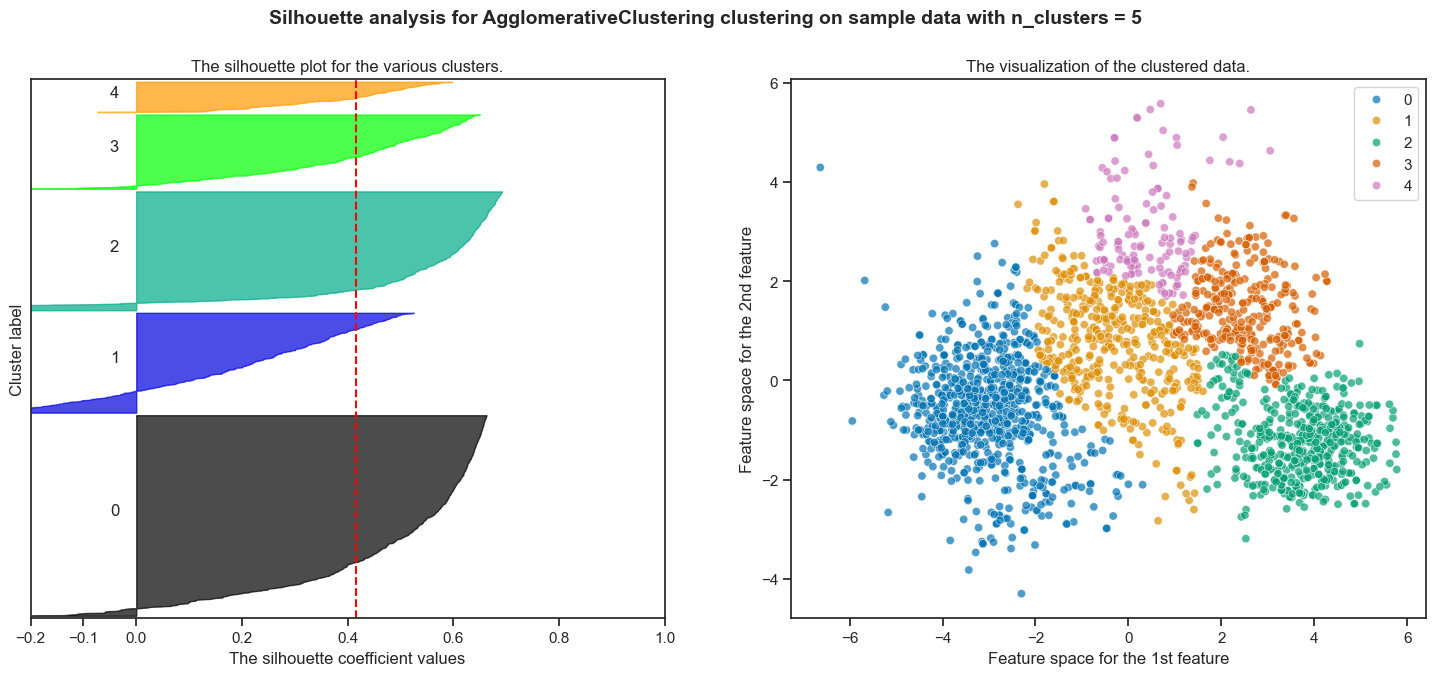

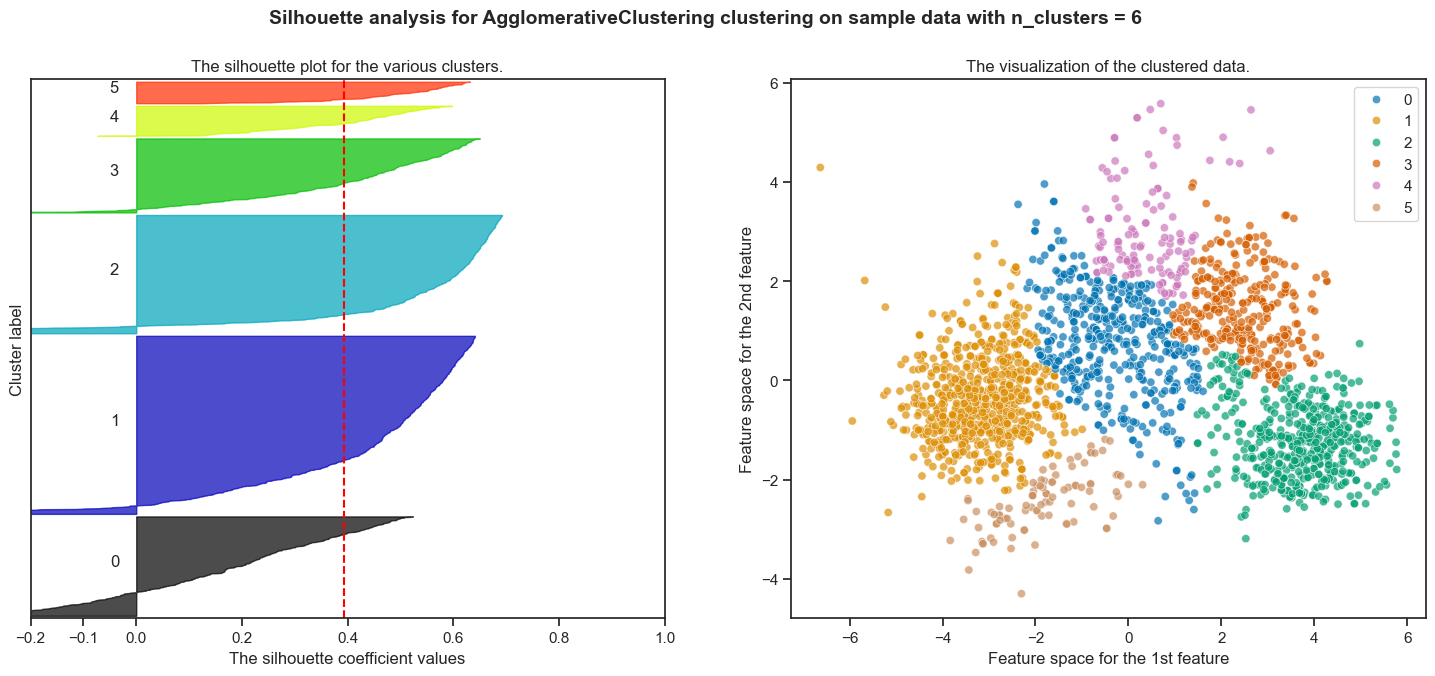

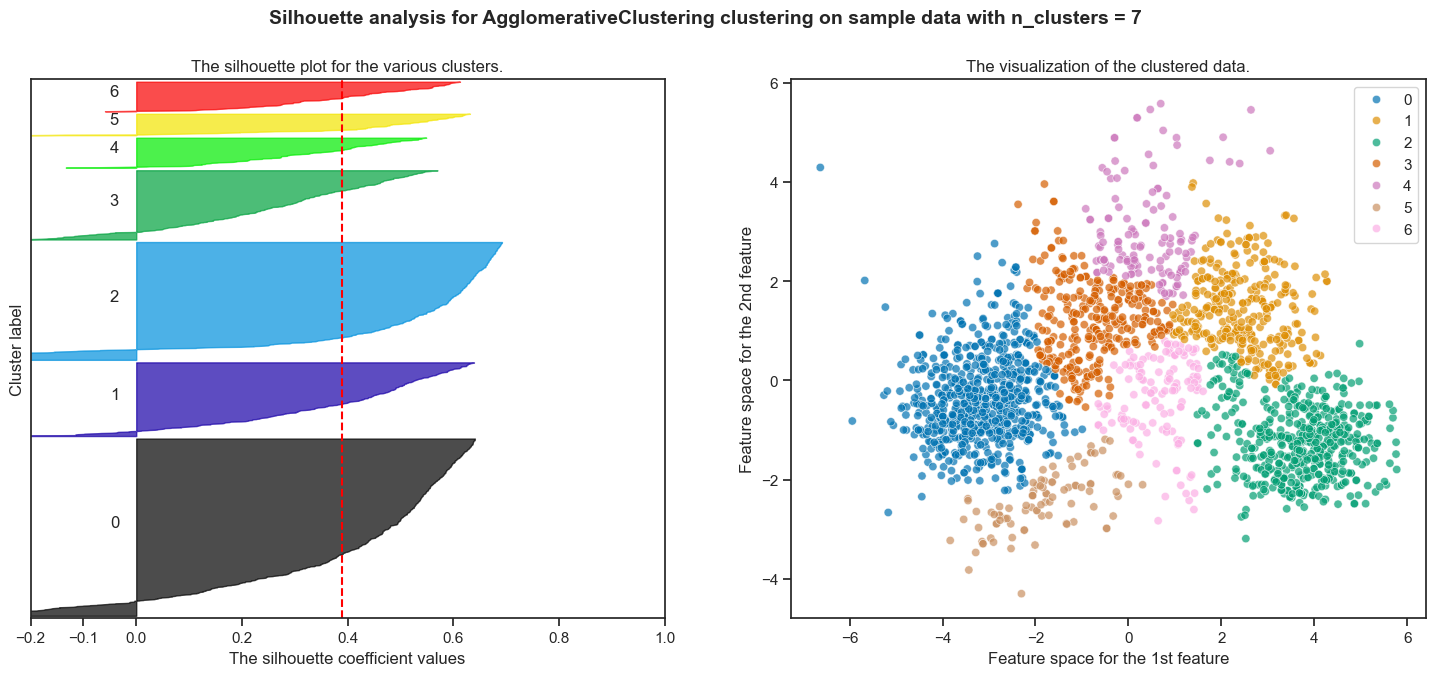

In [60]:
from sklearn.cluster import AgglomerativeClustering
#Plot Score to choose best clusters
silhouette_plot(AgglomerativeClustering,range(3,8),pcadf,reduced)

best average silhouette_score is : 0.479

### For n_clusters = 3 The average silhouette_score is : 0.4793304219958075
### for n_clusters = 4 The average silhouette_score is : 0.4422221719419182
### for n_clusters = 5 The average silhouette_score is : 0.44374523677707167
### for n_clusters = 6 The average silhouette_score is : 0.37663609855276475
### for n_clusters = 7 The average silhouette_score is : 0.38077029061500806


**Conclusions**
* Clusters of 3 has good balance of Inertia and Shilloute score, we can go with with 3 clusters.


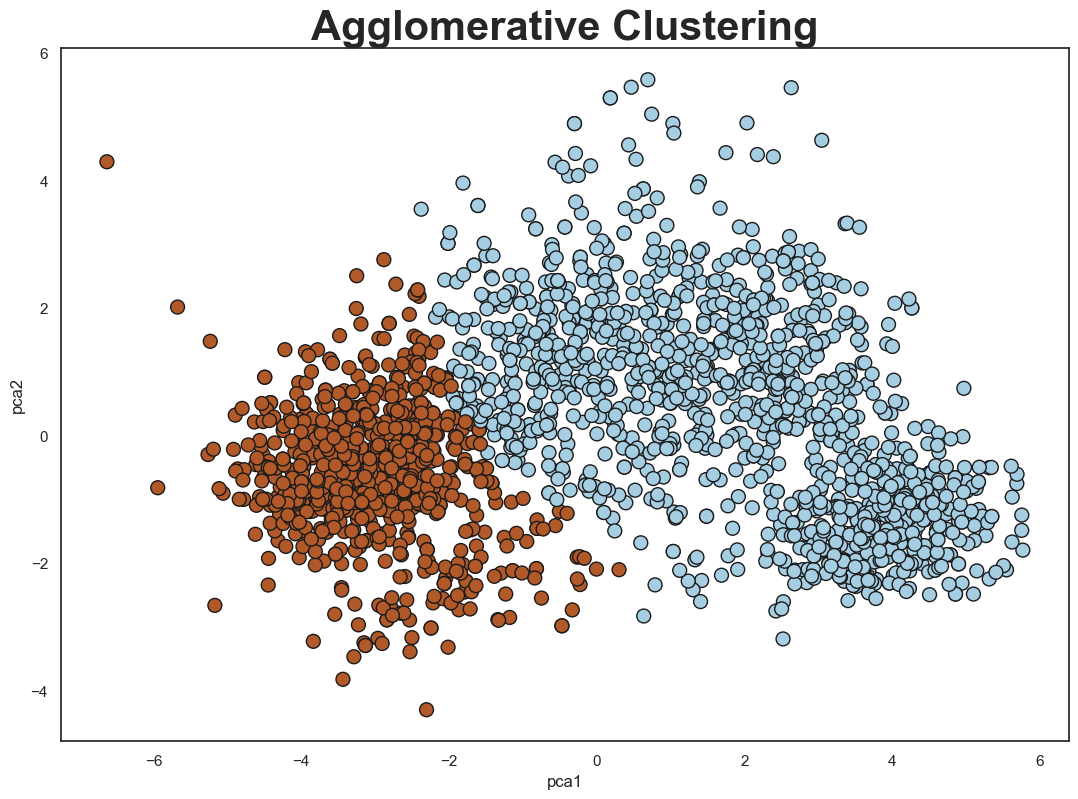

In [63]:
model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward').fit(reduced)
model_label = model.labels_
plt.figure(figsize=(13,9))

sns.set_style('white')
plt.title('Agglomerative Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=100, cmap='Paired', ec='k')

**Report**
* Agglomerative clustering performed well than K means clustering.
* The best Silhoutte score is 0.46, were as K means had 0.44 Silhoutte score.

## Gaussian Mixture
- A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.
- One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

For n_clusters = 3 The average silhouette_score is : 0.47683456769717075
For n_clusters = 4 The average silhouette_score is : 0.44523570763355125
For n_clusters = 5 The average silhouette_score is : 0.44195732180542197
For n_clusters = 6 The average silhouette_score is : 0.40960304094840694
For n_clusters = 7 The average silhouette_score is : 0.3776826979846894


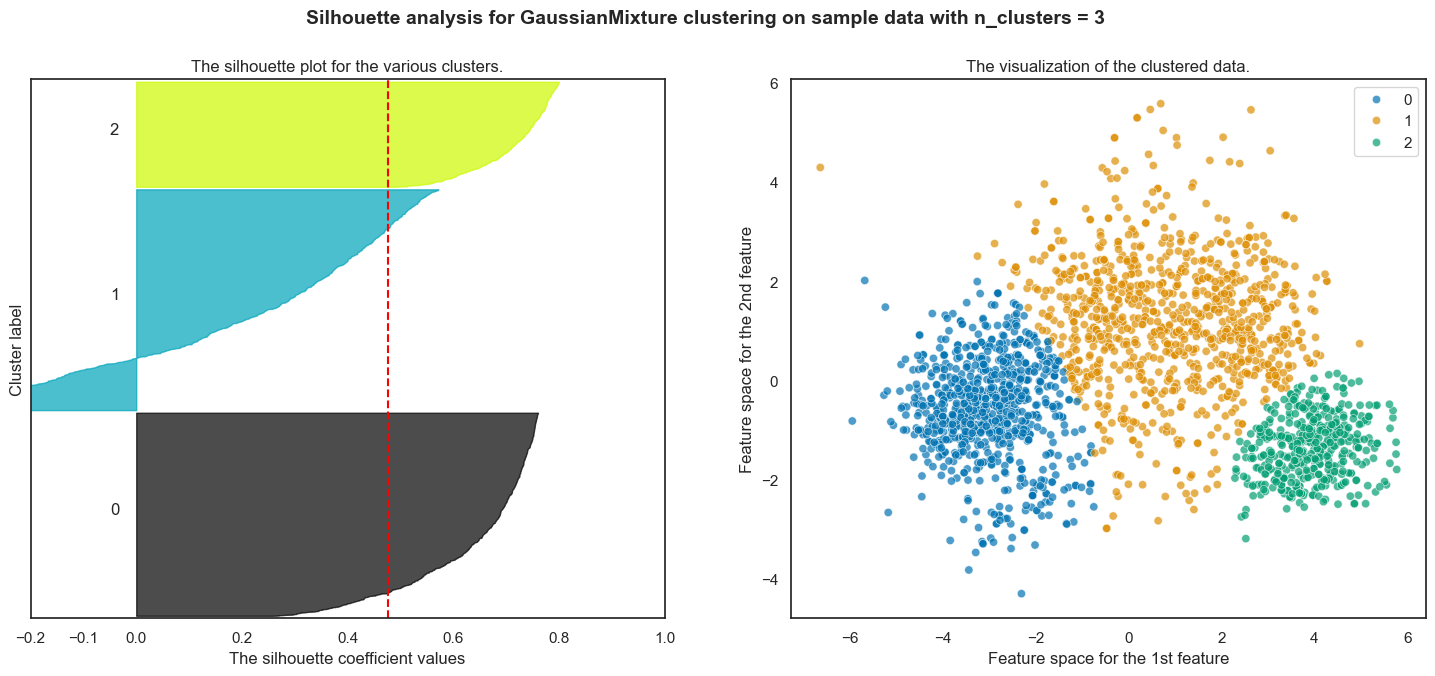

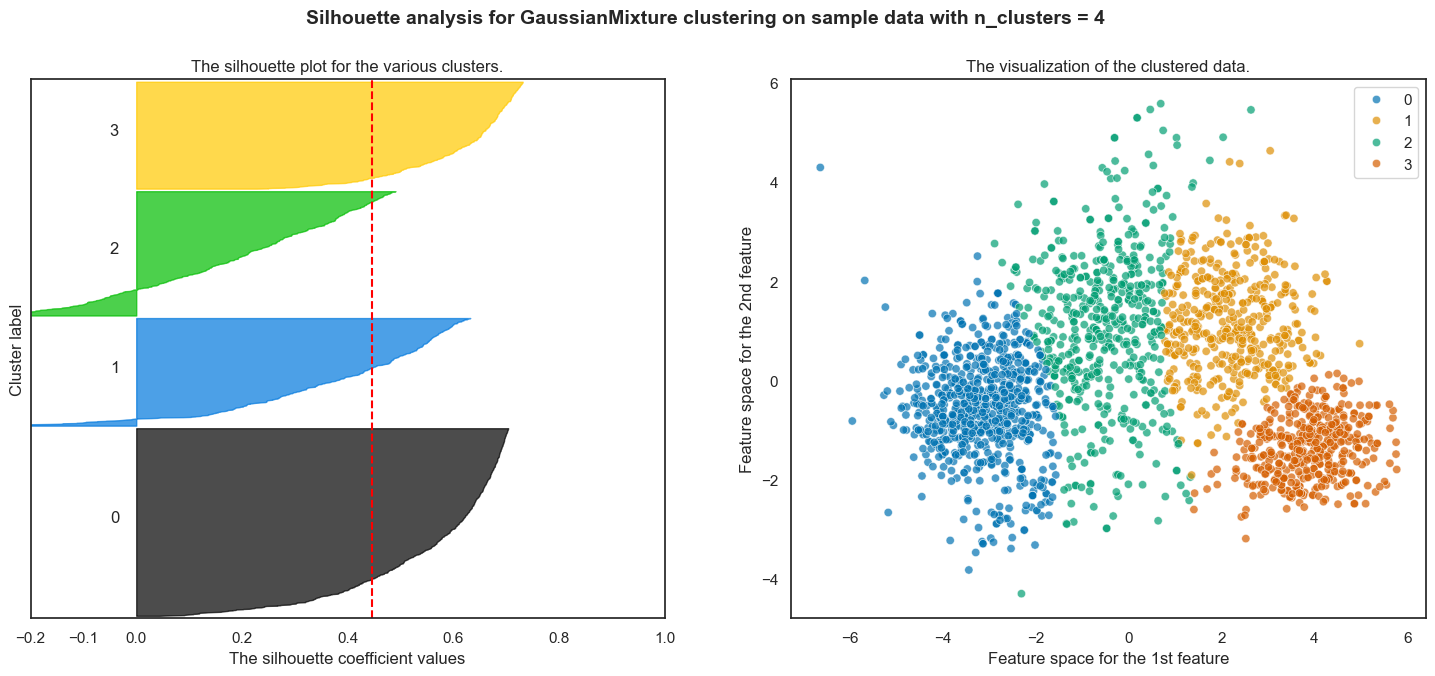

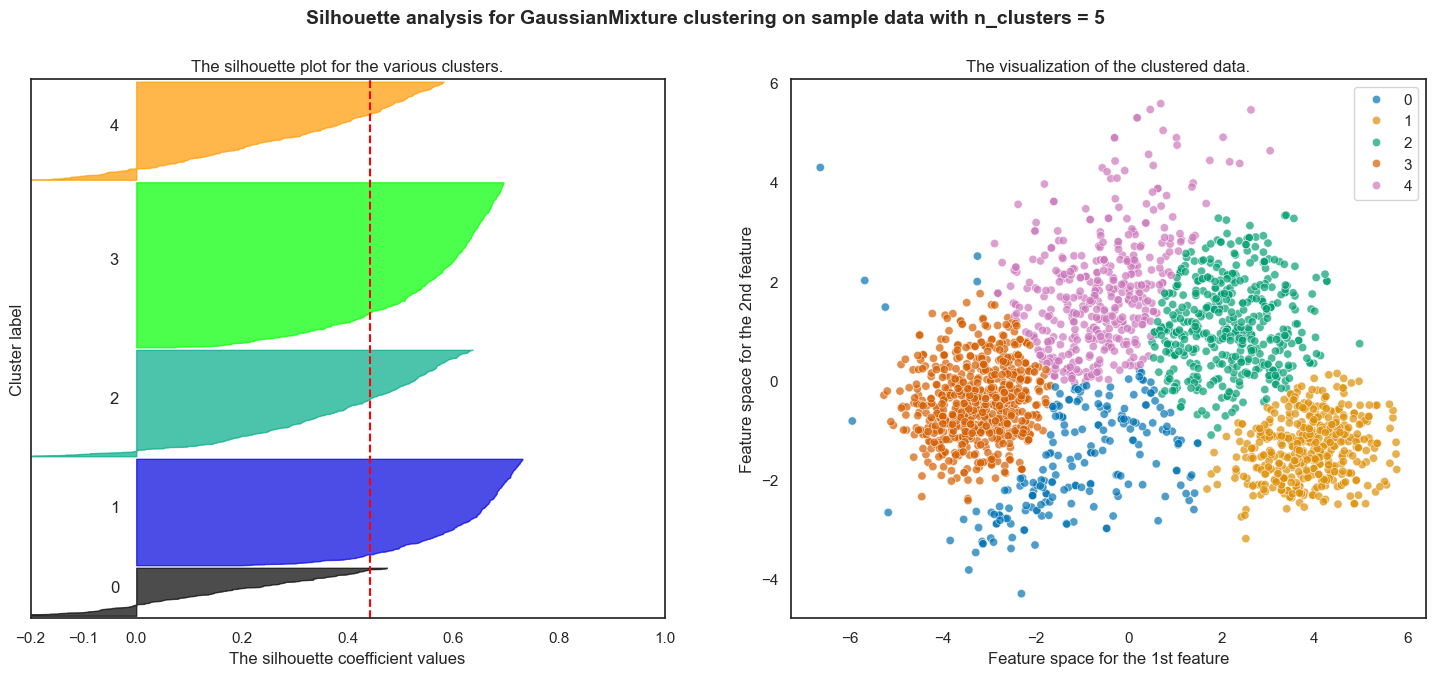

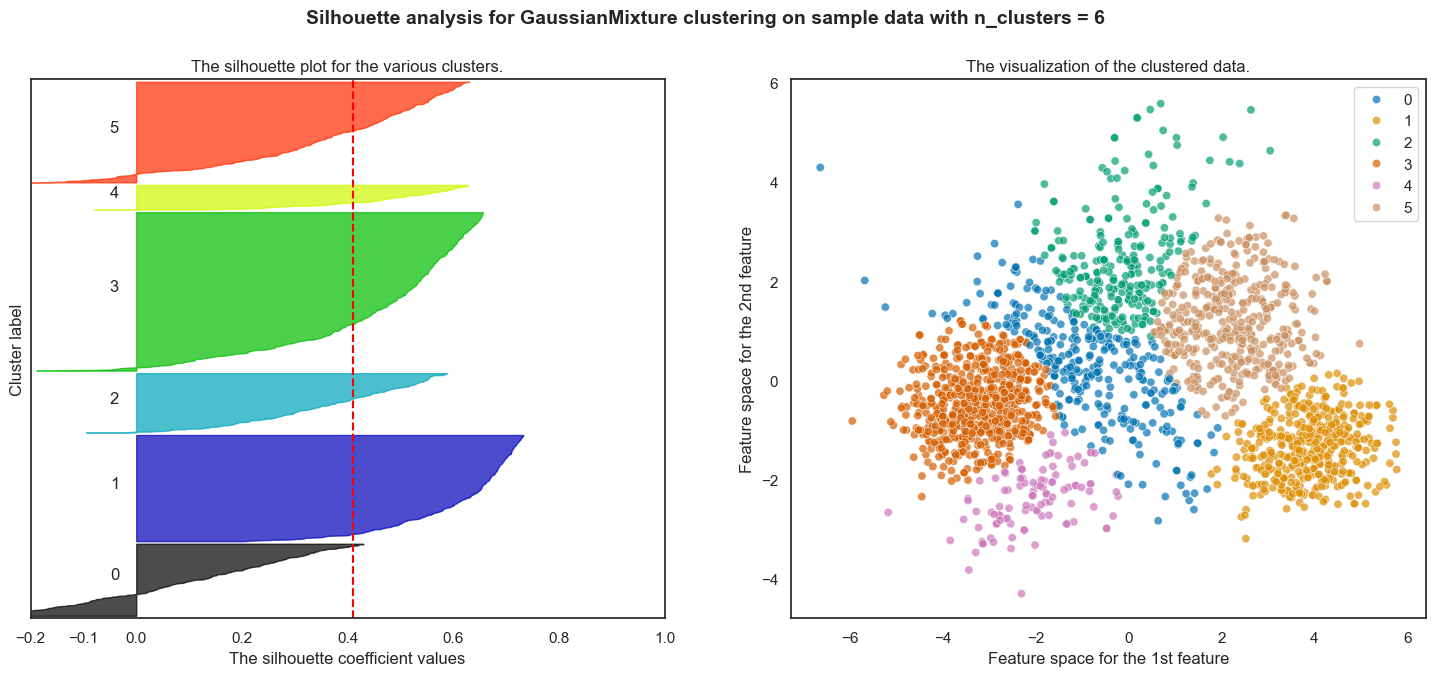

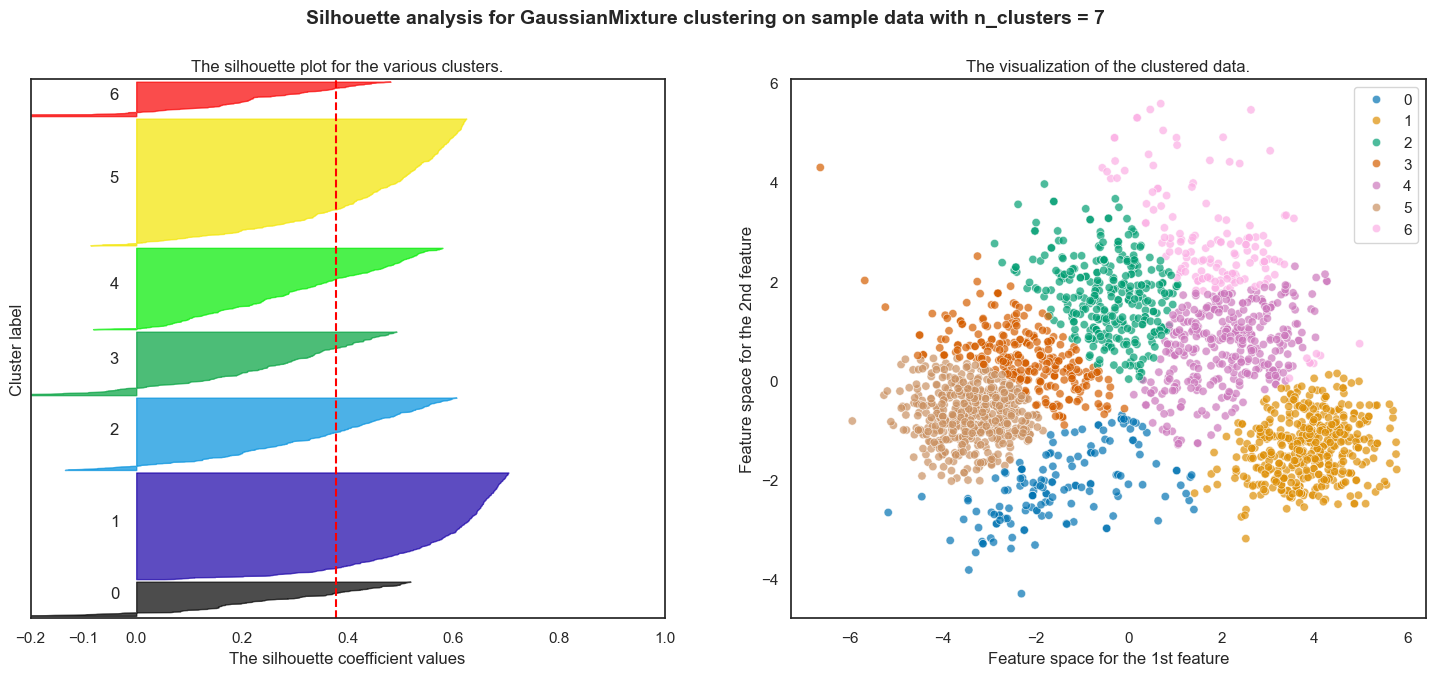

In [64]:
#plotting silhoutte score for Gaussian score
from sklearn.mixture import GaussianMixture
silhouette_plot(GaussianMixture,range(3,8),pcadf,reduced)

### for Gaussian Mixture
#### For n_clusters = 3 The average silhouette_score is : 0.47

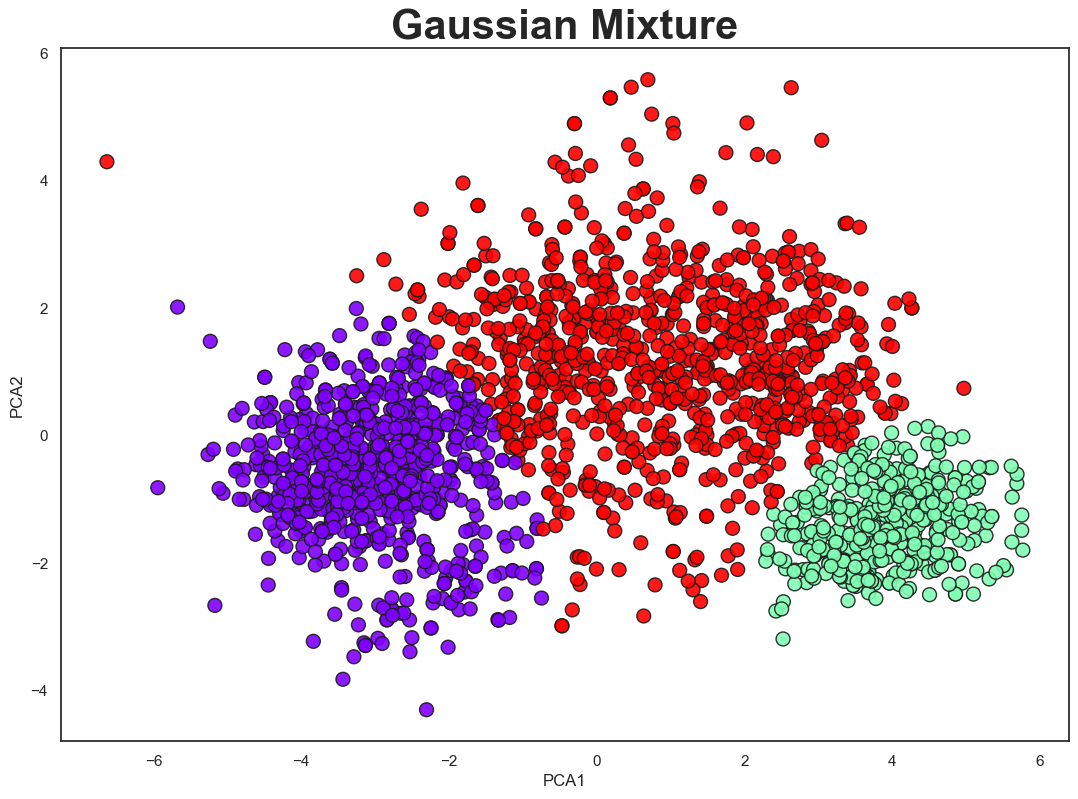

In [65]:
#plotting gaussian mixture with 4 clusters
model = GaussianMixture(n_components=3,random_state=42).fit(reduced)
model_label = model.predict(reduced)
plt.figure(figsize=(13,9))

sns.set_style('white')
plt.title('Gaussian Mixture', weight='bold', size=30)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=100, cmap='rainbow', ec='k', alpha=0.9)

### DBSCAN Clustering
* Density-based spatial clustering of applications with noise (DBSCAN) is a data clustering algorithm.
* DBSCAN algorithm group points based on distance measurement, usually the Euclidean distance and the minimum number of points. An essential property of this algorithm is that it helps us track down the outliers as the points in low-density regions; hence it is not sensitive to outliers as is the case of K-Means clustering.

**Minimum Points minPts**

In DBSCAN minPts is the minimum number of data points that should be there in the region to define the cluster. You can choose the value of minPts based on your domain knowledge. But if you lack domain knowledge a good reference point is to have minPts ≥ D + 1 where D is the dimension of the dataset.

It is recommended to keep the value for the minPts at least 3, but for larger data sets, a greater minPts value should be chosen, especially if it has many outliers.

### Finding the Optimal value of Epsilon

Rather than experimenting with different values of epsilon, we can use the elbow point detection method to arrive at a suitable value of epsilon.

In this approach, the average distance between each point and its k nearest neighbors is calculated where k = the MinPts selected.


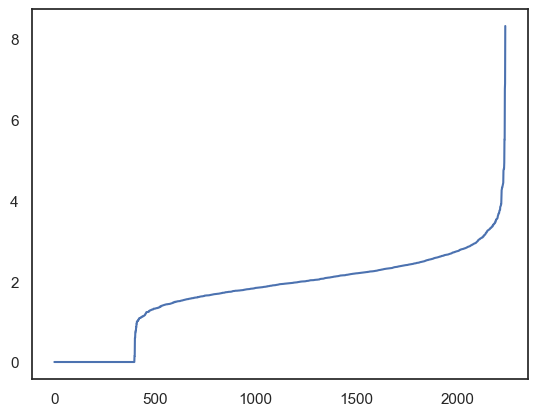

In [66]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

neighbors = NearestNeighbors(n_neighbors=17)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

distances = np.sort(distances, axis=0)

distances = distances[:,1]
plt.plot(distances)
plt.show()

### **Kneedle algorithm**
* We’ll use the Kneedle algorithm here via Kevin Arvai’s excellent Python implementation called Kneed. You can download this via PyPi by entering `pip3 install kneed` into your terminal and then importing the package with `from kneed import KneeLocator`.

<Figure size 500x500 with 0 Axes>

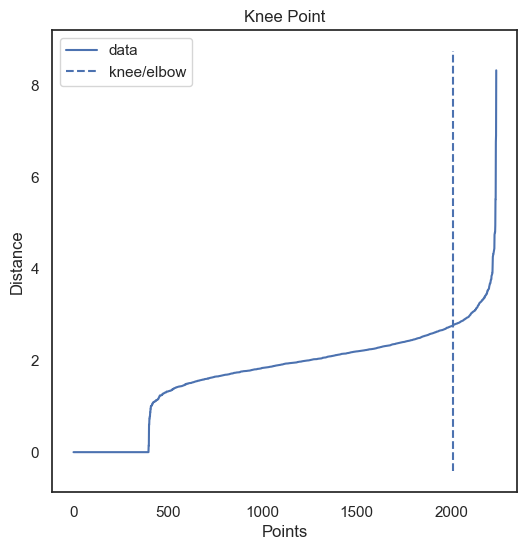

Knee Locator k = 2.7562617300106487


In [68]:
!pip install kneed
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k= distances[knee.knee]
print('Knee Locator k =', k)

### For 2-dimensional data, use DBSCAN’s default value of MinPts = 4 (Ester et al., 1996).

**DBSCAN algorithm works with two parameters.**

These parameters are:

* Epsilon (Eps): This is the least distance required for two points to be termed as a neighbor. This distance is known as Epsilon (Eps). Thus we consider Eps as a threshold for considering two points as neighbors, i.e., if the distance between two points is utmost Eps, then we consider the two points to be neighbors.

* MinPoints: This refers to the minimum number of points needed to construct a cluster. We consider MinPoints as a threshold for considering a cluster as a cluster. A cluster is only recognized if the number of points is greater than or equal to the MinPts.



AttributeError: Line2D.set() got an unexpected keyword argument 'cmap'

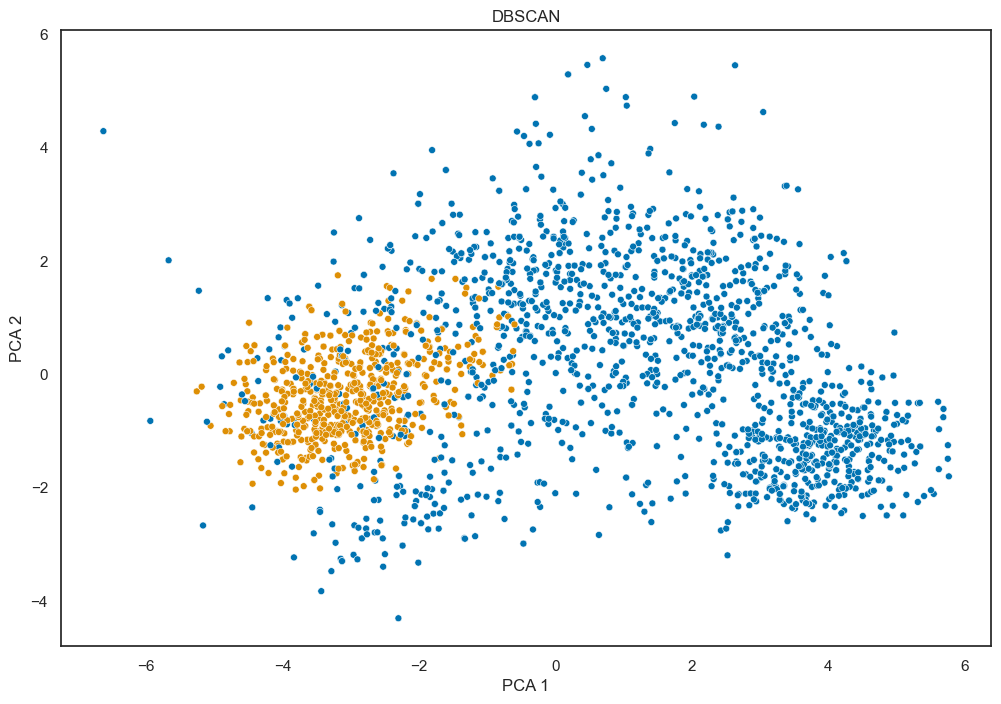

In [72]:
model=DBSCAN(eps=k , min_samples=100).fit(df_scaled)
model_label = model.labels_
plt.figure(figsize=(12,8))

plt.title('DBSCAN')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
scatter = sns.scatterplot(x = reduced[:,0], y = reduced[:,1], hue= model_label,
                      palette=sns.color_palette("colorblind", len(set(model_label))), s=25, cmap='Paired')

### DBSCAN didn't perform well in clustering.
- Its clear that DBSCAN does not work to well when we are dealing with clusters of varying densities or with high dimensional data

### Final Model

As Kmeans Clustering performed well than rest of the other algorithms, we will go with this

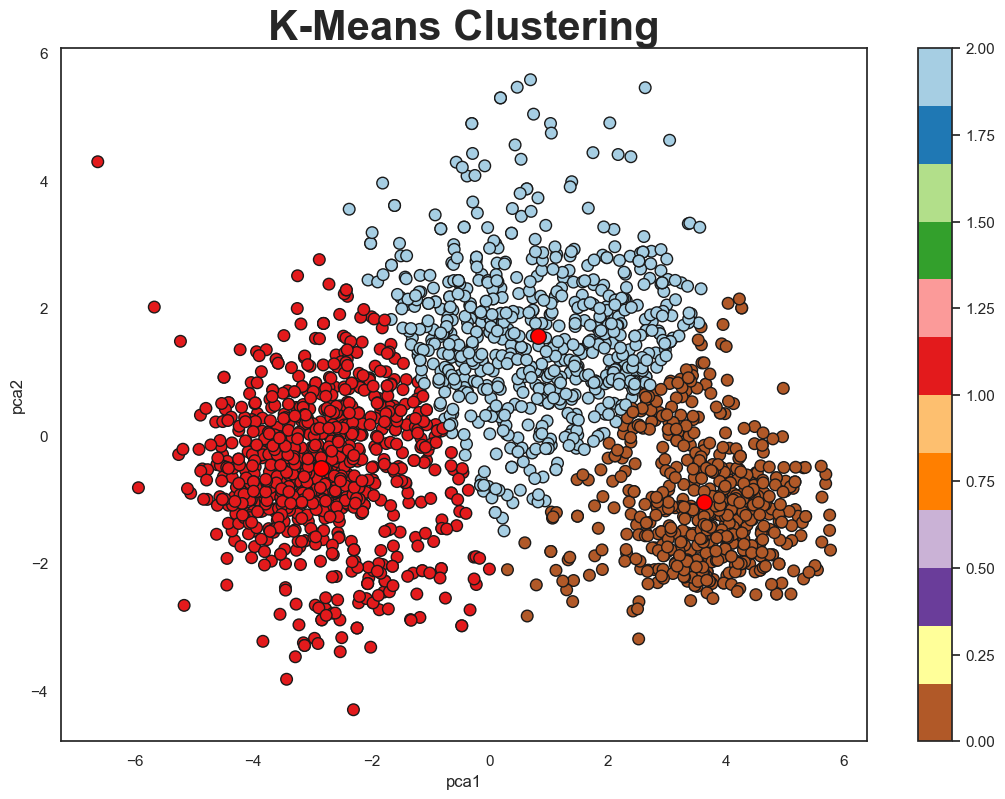

In [73]:

# Fitting the model to reduced data
model = KMeans(n_clusters=3).fit(pcadf)
model_label = model.labels_
model_centers = model.cluster_centers_

#Plotting the clusters
plt.figure(figsize=(13,9))
plt.title('K-Means Clustering', weight='bold', size=30)
plt.xlabel('pca1')
plt.ylabel('pca2')
scatter = plt.scatter(pcadf['PC1'], pcadf['PC2'], c=model_label, s=70, cmap='Paired_r', ec='k')
plt.colorbar(scatter)
plt.scatter(model_centers[:,0], model_centers[:,1], c='red', marker='.',s=500, ec='k');

### Saving the data with cluster column

In [79]:
#save model labels as new feature
import os
df["cluster"] = model.labels_.astype(int)
os.makedirs('data')
df.to_csv("./data/clustered_data.csv", index=False)

### Final report
- As we got the EDA results, we used that same approaches here also. We extracted out some features to derive valuable meanings from the data and used those in model training.
- The data had outliers and multicollinearity, We created pipelines to handle those things
- We have used PCA to minimize the dimensionality of the data.
- Kmeans Clustering algorithm has performed better then rest of the other clustering algorithms. So we went with it.